# Выпускной проект: промышленный

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. 


## Цель

Построить модель, которая будет предсказывать температуру стали.

## Задачи
- проанализировать доступные данные;
- обучить различные модели для определения наилучшей;
- протестировать обученные модели для выявления наилучшей и налаиза наиболее значимых факторов, влияющик на точность предсказания. 

## Описание этапа обработки стали

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав, добавляя куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем сплав перемешивают и снова проводят измерения. Такой цикл повторяется до тех пор, пока не будет достигнут нужный химический состав сплава и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

## Описание данных

Данные хранятся в таблицах в базе данных PostgreSQL:

    steel.data_arc — данные об электродах,
    steel.data_bulk — данные о подаче сыпучих материалов (объём),
    steel.data_bulk_time — данные о подаче сыпучих материалов (время),
    steel.data_gas — данные о продувке сплава газом,
    steel.data_temp — результаты измерения температуры,
    steel.data_wire — данные о проволочных материалах (объём),
    steel.data_wire_time — данные о проволочных материалах (время).

#### Таблица steel.data_arc

    `key` — номер партии,
    `BeginHeat` — время начала нагрева,
    `EndHeat` — время окончания нагрева,
    `ActivePower` — значение активной мощности,
    `ReactivePower` — значение реактивной мощности.

#### Таблица steel.data_bulk

    `key` — номер партии,
    `Bulk1` … Bulk15 — объём подаваемого материала.

#### Таблица steel.data_bulk_time

    `key` — номер партии,
    `Bulk1` … `Bulk15` — время подачи материала.

#### Таблица steel.data_gas

    `key` — номер партии,
    `gas` — объём подаваемого газа.

#### Таблица steel.data_temp

    `key` — номер партии,
    `MesaureTime` — время замера,
    `Temperature` — значение температуры.

#### Таблица steel.data_wire

    `key` — номер партии,
    `Wire1` … `Wire15` — объём подаваемых проволочных материалов.

#### Таблица steel.data_wire_time

    `key` — номер партии,
    `Wire1` … `Wire15` — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

Наша цель прогнозировать значение самого последнего замера температуру стали перед её отправкой на последующие этапы обработки.

In [2]:
import numpy as np

np.random.seed(42)  # до импорта keras

In [3]:
import random
import warnings
from copy import deepcopy
from datetime import datetime, timedelta

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from lightgbm import LGBMRegressor
from packaging import version
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine
from tensorflow import train
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import set_random_seed
from tqdm import tqdm

In [9]:
if version.parse(sns.__version__) < version.parse("0.12.0"):
    !pip install seaborn -U

     |████████████████████████████████| 285 kB 1.2 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


In [4]:
try:
    import keras_tuner
except ModuleNotFoundError:
    !pip install keras-tuner -q
    import keras_tuner

In [5]:
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

## Загрузка и анализ данных

In [6]:
db_config = {
    "user": "praktikum_student",
    "pwd": "Sdf4$2;d-d30pp",
    "host": "rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net",
    "port": 6432,
    "db": "data-science-final",
}

connection_string = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
engine = create_engine(connection_string)

In [73]:
pd.read_sql_query(
    "select * from steel.data_temp", con=engine)

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0
...,...,...,...
15902,3241,04:03:30,1586.0
15903,3241,04:16:12,NaN
15904,3241,04:22:39,NaN
15905,3241,04:33:42,NaN


In [69]:
query = """
SELECT *
FROM pg_catalog.pg_tables
WHERE schemaname != 'pg_catalog' AND 
    schemaname != 'information_schema'
"""

pd.read_sql_query(query, con=engine)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
0,steel,data_arc,praktikum_admin,None,False,False,False,False
1,steel,data_bulk,praktikum_admin,None,False,False,False,False
2,steel,data_bulk_time,praktikum_admin,None,False,False,False,False
3,steel,data_gas,praktikum_admin,None,False,False,False,False
4,steel,data_temp,praktikum_admin,None,False,False,False,False
5,steel,data_wire,praktikum_admin,None,False,False,False,False
6,steel,data_wire_time,praktikum_admin,None,False,False,False,False
7,telecom,personal,praktikum_admin,None,False,False,False,False
8,telecom,phone,praktikum_admin,None,False,False,False,False
9,telecom,contract,praktikum_admin,None,False,False,False,False


In [71]:
fmt = '%Y-%m-%d %H:%M:%S' #"%H:%M:%S"
data_arc = pd.read_sql_query(
    "select * from steel.data_arc",
    parse_dates={"BeginHeat": fmt, "EndHeat": fmt},
    con=engine,
)
data_bulk = pd.read_sql_query("select * from steel.data_bulk", con=engine)
data_bulk_time = pd.read_sql_query(
    "select * from steel.data_bulk_time",
    parse_dates={
        "Bulk 1": fmt,
        "Bulk 2": fmt,
        "Bulk 3": fmt,
        "Bulk 4": fmt,
        "Bulk 5": fmt,
        "Bulk 6": fmt,
        "Bulk 7": fmt,
        "Bulk 8": fmt,
        "Bulk 9": fmt,
        "Bulk 10": fmt,
        "Bulk 11": fmt,
        "Bulk 12": fmt,
        "Bulk 13": fmt,
        "Bulk 14": fmt,
        "Bulk 15": fmt,
    },
    con=engine,
)
data_gas = pd.read_sql_query("select * from steel.data_gas", con=engine)
data_temp = pd.read_sql_query(
    "select * from steel.data_temp", parse_dates={"MesaureTime": fmt}, con=engine
)
data_wire = pd.read_sql_query("select * from steel.data_wire", con=engine)
data_wire_time = pd.read_sql_query(
    "select * from steel.data_wire_time",
    parse_dates={
        "Wire 1": fmt,
        "Wire 2": fmt,
        "Wire 3": fmt,
        "Wire 4": fmt,
        "Wire 5": fmt,
        "Wire 6": fmt,
        "Wire 7": fmt,
        "Wire 8": fmt,
        "Wire 9": fmt,
        "Wire 10": fmt,
        "Wire 11": fmt,
        "Wire 12": fmt,
        "Wire 13": fmt,
        "Wire 14": fmt,
        "Wire 15": fmt,
    },
    con=engine,
)

### Данные о нагреве

In [72]:
data_arc.head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,NaT,NaT,0.98,0.69
1,1,NaT,NaT,0.81,0.52
2,1,NaT,NaT,0.74,0.50
3,1,NaT,NaT,1.66,1.06
4,1,NaT,NaT,0.69,0.41


Для порядка будем приводить названия признаков к snake case

In [10]:
data_arc.columns = ["key", "begin_heat", "end_heat", "active_power", "reactive_power"]

In [11]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   begin_heat      14876 non-null  datetime64[ns]
 2   end_heat        14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [12]:
data_arc.describe()

,key,active_power,reactive_power
count,14876.00,14876.00,14876.00
mean,1615.22,0.67,0.45
std,934.57,0.41,5.88
min,1.00,0.03,-715.50
25%,806.00,0.40,0.29
50%,1617.00,0.56,0.42
75%,2429.00,0.86,0.64
max,3241.00,3.73,2.68


В наборе данных `data_arc` присутствует 14876 записей без явных пропусков. При этом признак ReactivePower имеет подозрительное минимальное значение -715,5 при том, что первая четвертиль 0,29, а максимум 2,68. Из общих соображений мощность не должна быть меньше нуля. Это явно ошибка в данных.

In [13]:
data_arc[data_arc["reactive_power"] < 0.03]

,key,begin_heat,end_heat,active_power,reactive_power
676,146,1900-01-01 19:18:55,1900-01-01 19:19:07,0.04,0.02
2420,521,1900-01-01 17:42:57,1900-01-01 17:43:11,0.03,0.02
3199,692,1900-01-01 23:37:14,1900-01-01 23:37:28,0.05,0.03
4064,873,1900-01-01 18:34:19,1900-01-01 18:34:30,0.04,0.02
4616,996,1900-01-01 22:06:27,1900-01-01 22:09:03,0.04,0.03
4634,1000,1900-01-01 01:17:44,1900-01-01 01:17:57,0.04,0.02
4915,1060,1900-01-01 04:31:57,1900-01-01 04:32:08,0.03,0.02
5321,1154,1900-01-01 08:35:37,1900-01-01 08:35:48,0.03,0.03
5597,1216,1900-01-01 08:22:19,1900-01-01 08:22:30,0.03,0.02
6581,1432,1900-01-01 21:13:19,1900-01-01 21:13:34,0.03,0.03


Видно, что, по крайней мере, в области малых значений активной и реактивной можности, они более-менее близки. При этом аномальному значению реактивной мощности соответствует активная мощность со значением 0,5, близкая к медианному значению. Разумно будет заменить и аномальное значение медианным значением реактивной мощности

In [14]:
data_arc.loc[data_arc["reactive_power"] < 0, "reactive_power"] = data_arc[
    "reactive_power"
].median()

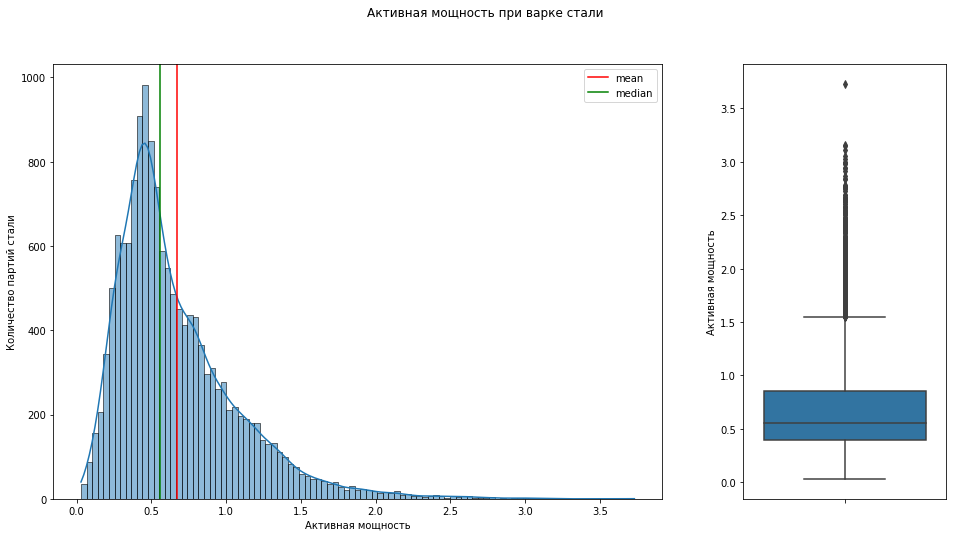

In [15]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 8), gridspec_kw={"width_ratios": [3, 1]}
)
plt.suptitle("Активная мощность при варке стали")

sns.histplot(data=data_arc, x="active_power", ax=ax1, kde=True)
ax1.axvline(x=data_arc["active_power"].mean(), color="red")
ax1.axvline(x=data_arc["active_power"].median(), color="green")

l1 = mlines.Line2D([], [], color="red", label="mean")
l2 = mlines.Line2D([], [], color="green", label="median")
ax1.legend(handles=[l1, l2])

sns.boxplot(data=data_arc, y="active_power", ax=ax2)

ax1.set(xlabel="Активная мощность", ylabel="Количество партий стали")
ax2.set(ylabel="Активная мощность");

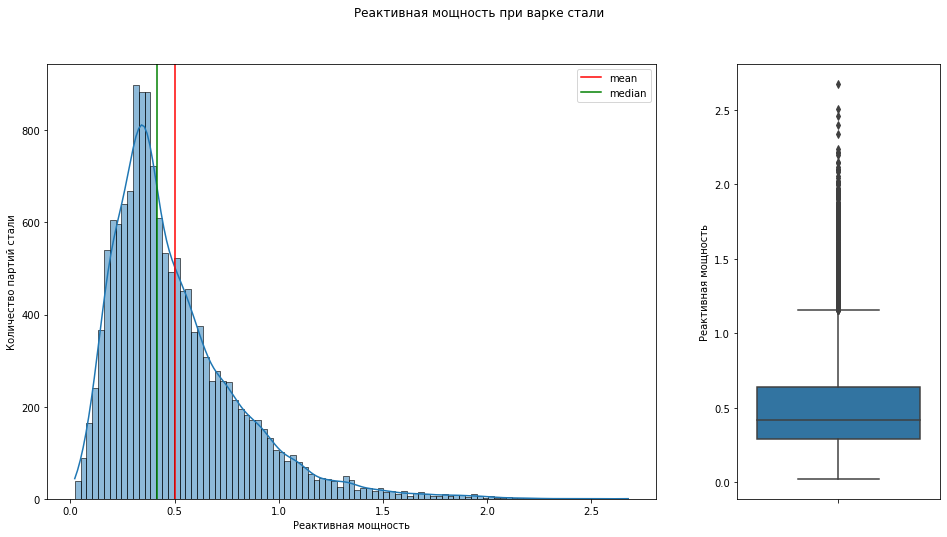

In [16]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 8), gridspec_kw={"width_ratios": [3, 1]}
)
plt.suptitle("Реактивная мощность при варке стали")

sns.histplot(data=data_arc, x="reactive_power", ax=ax1, kde=True)
ax1.axvline(x=data_arc["reactive_power"].mean(), color="red")
ax1.axvline(x=data_arc["reactive_power"].median(), color="green")

l1 = mlines.Line2D([], [], color="red", label="mean")
l2 = mlines.Line2D([], [], color="green", label="median")
ax1.legend(handles=[l1, l2])

sns.boxplot(data=data_arc, y="reactive_power", ax=ax2)

ax1.set(xlabel="Реактивная мощность", ylabel="Количество партий стали")
ax2.set(ylabel="Реактивная мощность");

#### Вывод

Данные о работе дуговых электродов проверены, пропусков нет, но выявлена  аномалия в значении реактивной мощности. Исправлена заменой на медианное значение.

### Данные о сыпучих присадках

In [17]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [18]:
data_bulk.columns = [
    "key",
    "bulk_1",
    "bulk_2",
    "bulk_3",
    "bulk_4",
    "bulk_5",
    "bulk_6",
    "bulk_7",
    "bulk_8",
    "bulk_9",
    "bulk_10",
    "bulk_11",
    "bulk_12",
    "bulk_13",
    "bulk_14",
    "bulk_15",
]

In [19]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Видно, что не во всех плавки стали используются все 15 легирующих добавок. Некоторые добавки используются не часто, например, 8я - всего однажды, а 13я, 9я, 2я и 7я не более 25 раз (остальные более 170 раз). Это может стать проблемой при обучении. От этих добавок стоит избавиться, так как обучить модель на таком малом количестве событий не получится, только зашумлять данные

In [20]:
bulks_to_remove = ["bulk_2", "bulk_5", "bulk_7", "bulk_8", "bulk_9", "bulk_13"]
data_bulk.drop(columns=bulks_to_remove, inplace=True)

In [21]:
data_bulk.describe()

,key,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15
count,3129.00,252.00,1298.00,1014.00,576.00,176.00,177.00,2450.00,2806.00,2248.00
mean,1624.38,39.24,113.88,104.39,118.93,83.28,76.82,260.47,170.28,160.51
std,933.34,18.28,75.48,48.18,72.06,26.06,59.66,120.65,65.87,51.77
min,1.00,10.00,6.00,12.00,17.00,24.00,8.00,53.00,16.00,1.00
25%,816.00,27.00,58.00,72.00,69.75,64.00,25.00,204.00,119.00,105.00
50%,1622.00,31.00,97.50,102.00,100.00,86.50,64.00,208.00,151.00,160.00
75%,2431.00,46.00,152.00,133.00,157.00,102.00,106.00,316.00,205.75,205.00
max,3241.00,185.00,454.00,281.00,503.00,159.00,313.00,1849.00,636.00,405.00


In [22]:
data_bulk["key"].nunique(), data_bulk["key"].shape[0]

(3129, 3129)

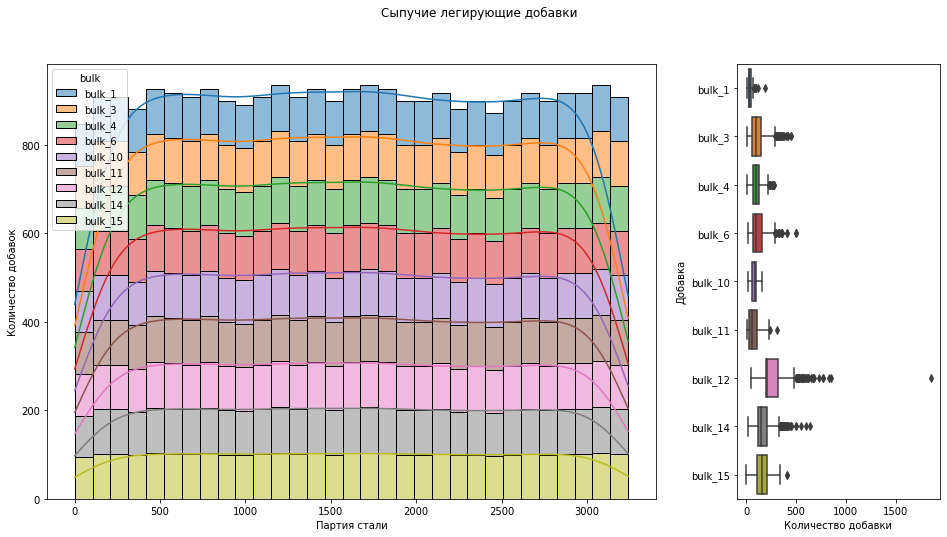

In [23]:
data = (
    data_bulk.set_index("key")
    .unstack()
    .reset_index()
    .rename(columns={"level_0": "bulk", 0: "value"})
)
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 8), gridspec_kw={"width_ratios": [3, 1]}
)
plt.suptitle("Сыпучие легирующие добавки")

sns.histplot(data=data, x="key", ax=ax1, kde=True, multiple="stack", hue="bulk")

sns.boxplot(data=data, x="value", y="bulk", ax=ax2)

ax1.set(xlabel="Партия стали", ylabel="Количество добавок")
ax2.set(xlabel="Количество добавки", ylabel="Добавка");

Видно, что одной партии стали ('key') соответствует одна и только одна запись в таблице data_bulk

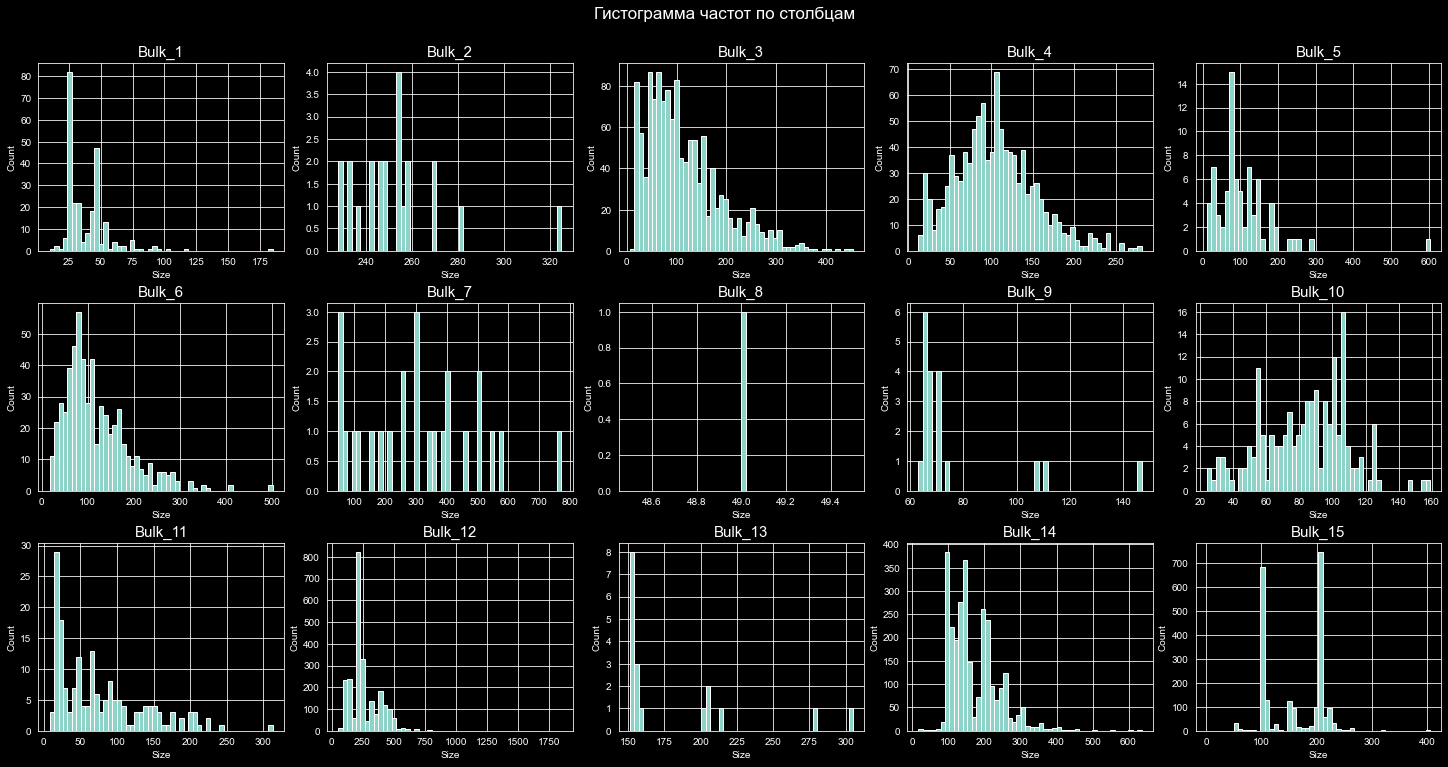

In [24]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,1900-01-01 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 11:03:52,NaT,1900-01-01 11:03:52,1900-01-01 11:03:52
1,2,NaT,NaT,NaT,1900-01-01 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 11:40:20,NaT,1900-01-01 11:40:20,1900-01-01 11:40:20
2,3,NaT,NaT,NaT,1900-01-01 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 12:09:40,NaT,1900-01-01 12:09:40,1900-01-01 12:09:40
3,4,NaT,NaT,NaT,1900-01-01 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 12:41:24,NaT,1900-01-01 12:41:24,1900-01-01 12:41:24
4,5,NaT,NaT,NaT,1900-01-01 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 13:12:56,NaT,1900-01-01 13:12:56,1900-01-01 13:12:56


In [25]:
data_bulk_time.columns = [
    "key",
    "bulk_1_time",
    "bulk_2_time",
    "bulk_3_time",
    "bulk_4_time",
    "bulk_5_time",
    "bulk_6_time",
    "bulk_7_time",
    "bulk_8_time",
    "bulk_9_time",
    "bulk_10_time",
    "bulk_11_time",
    "bulk_12_time",
    "bulk_13_time",
    "bulk_14_time",
    "bulk_15_time",
]

Удаляем добавки, которые уже удалили из data_bulk

In [26]:
bulks_to_remove = list(map(lambda x: x + "_time", bulks_to_remove))
data_bulk_time.drop(columns=bulks_to_remove, inplace=True)

In [27]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3129 non-null   int64         
 1   bulk_1_time   252 non-null    datetime64[ns]
 2   bulk_3_time   1298 non-null   datetime64[ns]
 3   bulk_4_time   1014 non-null   datetime64[ns]
 4   bulk_6_time   576 non-null    datetime64[ns]
 5   bulk_10_time  176 non-null    datetime64[ns]
 6   bulk_11_time  177 non-null    datetime64[ns]
 7   bulk_12_time  2450 non-null   datetime64[ns]
 8   bulk_14_time  2806 non-null   datetime64[ns]
 9   bulk_15_time  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 244.6 KB


In [28]:
data_bulk_time["key"].nunique(), data_bulk_time["key"].shape[0]

(3129, 3129)

Одна партия - одна запись в data_bulk_time

#### Вывод

Изучены данные о сыпучих легирующих добавках. Некоторые из них используются в очень небольшом количестве партий и были удалены

### Легирующие добавки в проволоке

In [29]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.24,9.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
data_wire.columns = [
    "key",
    "wire_1",
    "wire_2",
    "wire_3",
    "wire_4",
    "wire_5",
    "wire_6",
    "wire_7",
    "wire_8",
    "wire_9",
]

Так же как и сыпучие добавки, добавки в виде проволоки применяются не всегда, отсюда множественные пропуски в данных 

In [31]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [32]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.00,3055.00,1079.00,63.00,14.00,1.00,73.00,11.00,19.00,29.00
mean,1623.43,100.90,50.58,189.48,57.44,15.13,48.02,10.04,53.63,34.16
std,933.00,42.01,39.32,99.51,28.82,NaN,33.92,8.61,16.88,19.93
min,1.00,1.92,0.03,0.14,24.15,15.13,0.03,0.23,45.08,4.62
25%,823.00,72.12,20.19,95.14,40.81,15.13,25.05,6.76,46.09,22.06
50%,1619.00,100.16,40.14,235.19,45.23,15.13,42.08,9.02,46.28,30.07
75%,2434.00,126.06,70.23,276.25,76.12,15.13,64.21,11.89,48.09,43.86
max,3241.00,330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05


Видно, что только две присадки (Wire 1 и Wire 2) использовались достаточно часто, остальные менее 75 раз, а некоторые и менее 20 раз.

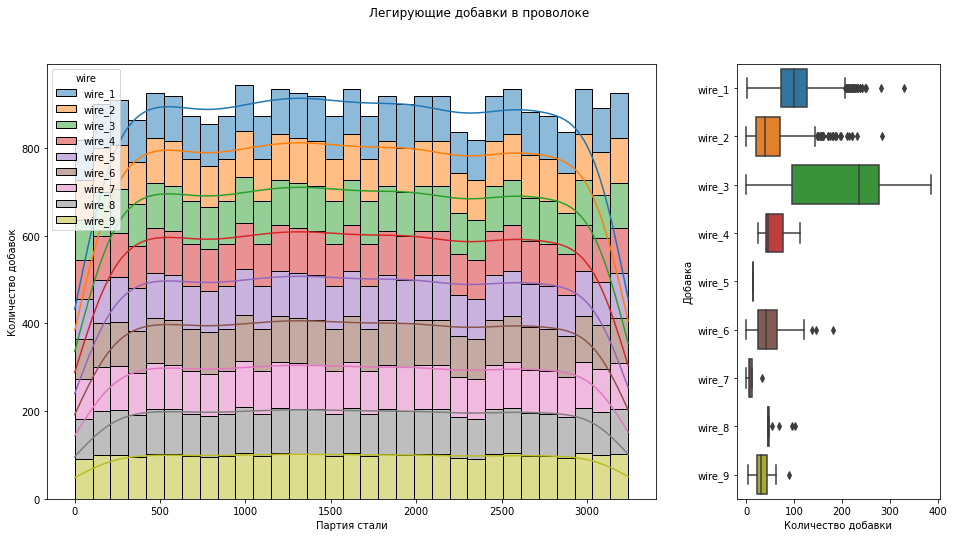

In [33]:
data = (
    data_wire.set_index("key")
    .unstack()
    .reset_index()
    .rename(columns={"level_0": "wire", 0: "value"})
)
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 8), gridspec_kw={"width_ratios": [3, 1]}
)
plt.suptitle("Легирующие добавки в проволоке")

sns.histplot(data=data, x="key", ax=ax1, kde=True, multiple="stack", hue="wire")

sns.boxplot(data=data, x="value", y="wire", ax=ax2)

ax1.set(xlabel="Партия стали", ylabel="Количество добавок")
ax2.set(xlabel="Количество добавки", ylabel="Добавка");

In [34]:
wires_to_remove = ["wire_3", "wire_4", "wire_5", "wire_6", "wire_7", "wire_8", "wire_9"]
data_wire = data_wire.drop(columns=wires_to_remove)

In [35]:
data_wire_time.columns = [
    "key",
    "wire_1_time",
    "wire_2_time",
    "wire_3_time",
    "wire_4_time",
    "wire_5_time",
    "wire_6_time",
    "wire_7_time",
    "wire_8_time",
    "wire_9_time",
]

In [36]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          3081 non-null   int64         
 1   wire_1_time  3055 non-null   datetime64[ns]
 2   wire_2_time  1079 non-null   datetime64[ns]
 3   wire_3_time  63 non-null     datetime64[ns]
 4   wire_4_time  14 non-null     datetime64[ns]
 5   wire_5_time  1 non-null      datetime64[ns]
 6   wire_6_time  73 non-null     datetime64[ns]
 7   wire_7_time  11 non-null     datetime64[ns]
 8   wire_8_time  19 non-null     datetime64[ns]
 9   wire_9_time  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [37]:
wires_to_remove = list(map(lambda x: x + "_time", wires_to_remove))
data_wire_time = data_wire_time.drop(columns=wires_to_remove)

In [38]:
data_wire_time["key"].nunique(), data_wire_time["key"].shape[0]

(3081, 3081)

Одной паритии стали соответствует одна запись в таблице

#### Вывод

Пропусков и аномалий в данных о добавках в проволоке не обнаружено. Некоторые добавки использовались при варке стали очень редко и были удалены.

### Продувка газом

In [39]:
data_gas.head()

,key,gas
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41


In [40]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [41]:
data_gas["key"].nunique(), data_gas["key"].shape[0]

(3239, 3239)

Видно, что в этой таблице также одной партии соответствует одна запись, но партий больше, чем в предыдущих таблицах. Очевидно, не для каждой стали использовались сыпучии добавки. Газом же продувают все партии стали.

In [42]:
data_gas.describe()

,key,gas
count,3239.00,3.24e+03
mean,1621.86,1.10e+01
std,935.39,6.22e+00
min,1.00,8.40e-03
25%,812.50,7.04e+00
50%,1622.00,9.84e+00
75%,2431.50,1.38e+01
max,3241.00,7.80e+01


Аномалий или пропусков в данных о продувку газом не заметно.

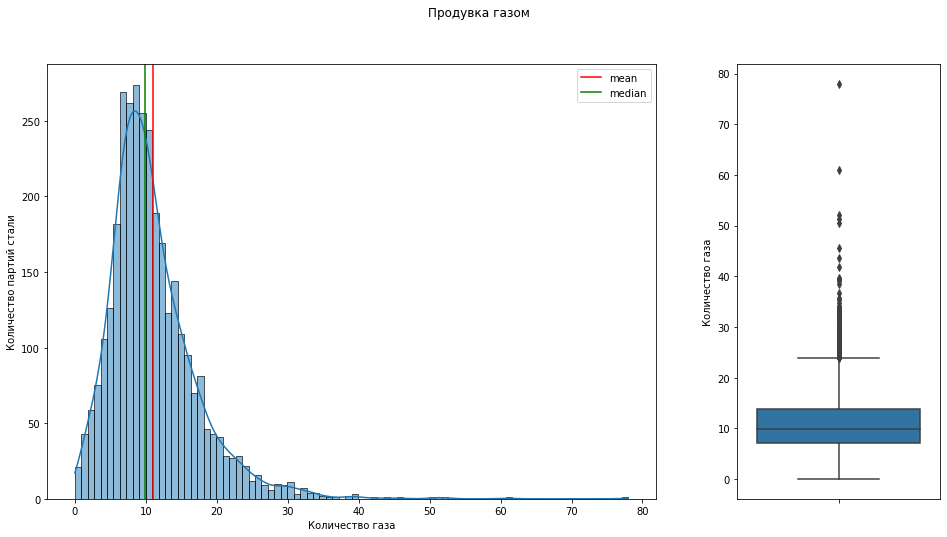

In [43]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 8), gridspec_kw={"width_ratios": [3, 1]}
)
plt.suptitle("Продувка газом")

sns.histplot(data=data_gas, x="gas", ax=ax1, kde=True)
ax1.axvline(x=data_gas["gas"].mean(), color="red")
ax1.axvline(x=data_gas["gas"].median(), color="green")

l1 = mlines.Line2D([], [], color="red", label="mean")
l2 = mlines.Line2D([], [], color="green", label="median")
ax1.legend(handles=[l1, l2])

sns.boxplot(data=data_gas, y="gas", ax=ax2)

ax1.set(xlabel="Количество газа", ylabel="Количество партий стали")
ax2.set(ylabel="Количество газа");

#### Вывод

Данные по газу в порядке: одной партии соответствует одна запись, нет пропусков и аномалий.

### Замеры температуры

In [44]:
data_temp.head(10)

,key,MesaureTime,Temperature
0,1,1900-01-01 11:16:18,1571.0
1,1,1900-01-01 11:25:53,1604.0
2,1,1900-01-01 11:29:11,1618.0
3,1,1900-01-01 11:30:01,1601.0
4,1,1900-01-01 11:30:39,1613.0
5,2,1900-01-01 11:37:27,1581.0
6,2,1900-01-01 11:38:00,1577.0
7,2,1900-01-01 11:49:38,1589.0
8,2,1900-01-01 11:55:50,1604.0
9,2,1900-01-01 11:58:24,1608.0


In [45]:
data_temp.columns = ["key", "measure_time", "temperature"]

In [46]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   measure_time  15907 non-null  datetime64[ns]
 2   temperature   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [47]:
data_temp.describe()

,key,temperature
count,15907.00,13006.00
mean,1607.88,1591.84
std,942.21,21.38
min,1.00,1191.00
25%,790.00,1581.00
50%,1618.00,1591.00
75%,2427.00,1601.00
max,3241.00,1705.00


Замеры температуры производятся достаточно регулярно, отклонения не велики и симметричны. На это указывает низкое значение дисперсии и почти точное совпадение значений среднего и медианы. В тоже время в замерах температуры имеются пропуски: около 2900 измерений из почти 16000 пропущены. 

In [48]:
(
    data_temp.loc[data_temp["temperature"].isna(), "key"].unique().shape[0],
    data_temp["key"].unique().shape[0],
)

(739, 3216)

Таким образом, из 3216 партий стали, хотя бы один пропуск замера температуры мимеется в 739. Ещё замечание: партий стали, о продувке газом которых есть сведения в таблице data_gas больше. Но партии, где нет сведений о замерах температур, могут стать проблемой.

Наиболее критичны для нас случаи, когда пропуск имеется в конечном замере температуры и случаи когда есть единственный замер температуры.

Заполним пропуски температуры "невозможными" значениями, поскольку ряд функций, в частности, last при работе отбрасывают NaN  

In [49]:
(data_temp.fillna(-1)[["temperature", "key"]].groupby("key").last() == -1).sum()

temperature    739
dtype: int64

Как видим, во всех 739 партиях с пропусками температуры, отсутствуют замеры в конце варки (целевой признак). Эти партии непригодны для работй и должны быть отброшены.

In [50]:
data_temp.head()

,key,measure_time,temperature
0,1,1900-01-01 11:16:18,1571.0
1,1,1900-01-01 11:25:53,1604.0
2,1,1900-01-01 11:29:11,1618.0
3,1,1900-01-01 11:30:01,1601.0
4,1,1900-01-01 11:30:39,1613.0


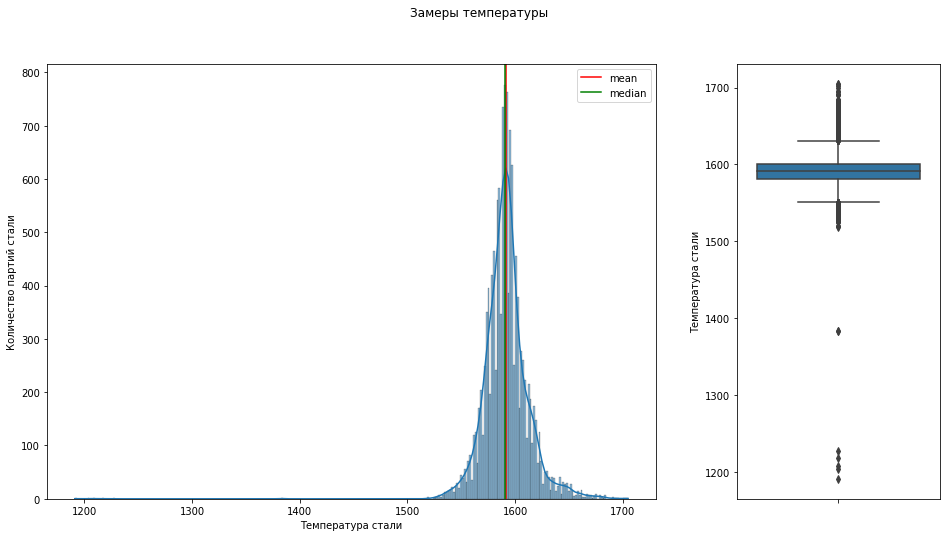

In [51]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 8), gridspec_kw={"width_ratios": [3, 1]}
)
plt.suptitle("Замеры температуры")

sns.histplot(data=data_temp[["key", "temperature"]], x="temperature", ax=ax1, kde=True)

ax1.axvline(x=data_temp["temperature"].mean(), color="red")
ax1.axvline(x=data_temp["temperature"].median(), color="green")
l1 = mlines.Line2D([], [], color="red", label="mean")
l2 = mlines.Line2D([], [], color="green", label="median")
ax1.legend(handles=[l1, l2])

sns.boxplot(data=data_temp, y="temperature", ax=ax2)

ax1.set(xlabel="Температура стали", ylabel="Количество партий стали")
ax2.set(ylabel="Температура стали");

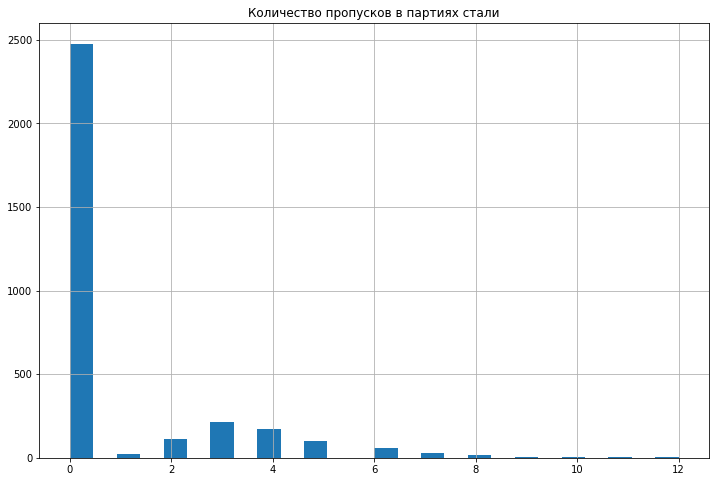

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
data_temp.groupby("key").agg({"temperature": lambda x: x.isna().sum()}).hist(
    bins=26, ax=ax
)
ax.set_title("Количество пропусков в партиях стали");

Видно, что у большего числа партий с пропусками пропусков 3 и более. Поскольку температура - один из ключевых показателей процесса варки стали и очевидных методов заполнения пропусков не видно (любые интерполяции рискуют исказить обучение моделей), пропуски придётся удалить. 

In [53]:
keys_to_delete = data_temp.loc[data_temp["temperature"].isna(), "key"].unique()
keys_to_delete

array([2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510,
       2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521,
       2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532,
       2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543,
       2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554,
       2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565,
       2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576,
       2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587,
       2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598,
       2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609,
       2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620,
       2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631,
       2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642,
       2643, 2644, 2645, 2646, 2647, 2648, 2649, 26

In [54]:
# и единичные замеры температуры в партии
t = data_temp.groupby("key").agg("count")["temperature"]
list(t[t == 1].index)

[195,
 279,
 2500,
 2501,
 2502,
 2503,
 2504,
 2505,
 2506,
 2507,
 2508,
 2509,
 2510,
 2511,
 2512,
 2513,
 2514,
 2515,
 2516,
 2517,
 2518,
 2519,
 2520,
 2521,
 2522,
 2523,
 2524,
 2525,
 2526,
 2527,
 2528,
 2529,
 2530,
 2531,
 2532,
 2533,
 2534,
 2535,
 2536,
 2537,
 2538,
 2539,
 2540,
 2541,
 2542,
 2543,
 2544,
 2545,
 2546,
 2547,
 2548,
 2549,
 2550,
 2551,
 2552,
 2553,
 2554,
 2555,
 2556,
 2557,
 2558,
 2559,
 2560,
 2561,
 2562,
 2563,
 2564,
 2565,
 2566,
 2567,
 2568,
 2569,
 2570,
 2571,
 2572,
 2573,
 2574,
 2575,
 2576,
 2577,
 2578,
 2579,
 2580,
 2581,
 2582,
 2583,
 2584,
 2585,
 2586,
 2587,
 2588,
 2589,
 2590,
 2591,
 2592,
 2593,
 2594,
 2595,
 2596,
 2597,
 2598,
 2599,
 2600,
 2601,
 2602,
 2603,
 2604,
 2605,
 2606,
 2607,
 2608,
 2609,
 2610,
 2611,
 2612,
 2613,
 2614,
 2615,
 2616,
 2617,
 2618,
 2619,
 2620,
 2621,
 2622,
 2623,
 2624,
 2625,
 2626,
 2627,
 2628,
 2629,
 2630,
 2631,
 2632,
 2633,
 2634,
 2635,
 2636,
 2637,
 2638,
 2639,
 2640,
 

In [55]:
keys_to_delete = list(keys_to_delete) + list(t[t == 1].index)

Любопытно, что проблемные партии идут подряд. Можно предположить, что начиная с партии 2500 имела место неисправность датчика температуры.

Удалим проблемные партии стали.

In [56]:
for df in [
    data_arc,
    data_temp,
    data_bulk,
    data_bulk_time,
    data_wire,
    data_wire_time,
    data_gas,
]:
    df.drop(index=df[df["key"].isin(keys_to_delete)].index, inplace=True)

### Вывод

Мы загрузили данные из PostgreSQL. Таблицы соответствую спецификации. В данных были обнаружены следующие ошибки:
1. одно отрицательное значение реактивной мощности заменено медианным значением;
1. в 739 партиях выявлены пропуски в значениях  целевго показателя (температуры в конце варки стали). 

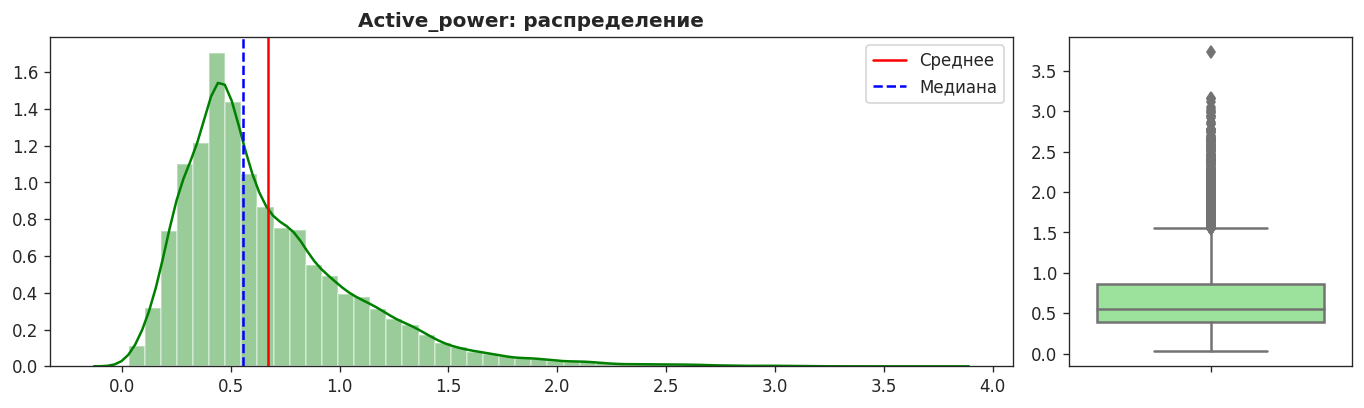

## ВременнЫе характеристики

В доступных данных имеется некоторая проблема: изначально нам доступно только время событий без даты, а значит в ряде случаев возможен переход через полночь. Когда последующее событие имеет временнУю метку меньше, чем предыдущее (23:59 -> 00:05). И это в самом деле имеет место   

In [57]:
temperature = data_temp.groupby("key").agg(["last", "first"])
temperature.columns = [
    "measure_time_last",
    "measure_time_first",
    "temperature_last",
    "temperature_first",
]

In [58]:
temperature["measure_duration"] = (
    temperature["measure_time_last"] - temperature["measure_time_first"]
)

In [59]:
temperature

,measure_time_last,measure_time_first,temperature_last,temperature_first,measure_duration
key,,,,,
1,1900-01-01 11:30:39,1900-01-01 11:16:18,1613.0,1571.0,0 days 00:14:21
2,1900-01-01 11:59:12,1900-01-01 11:37:27,1602.0,1581.0,0 days 00:21:45
3,1900-01-01 12:34:57,1900-01-01 12:13:17,1599.0,1596.0,0 days 00:21:40
4,1900-01-01 12:59:25,1900-01-01 12:52:57,1625.0,1601.0,0 days 00:06:28
5,1900-01-01 13:36:01,1900-01-01 13:23:19,1602.0,1576.0,0 days 00:12:42
...,...,...,...,...,...
2495,1900-01-01 00:54:42,1900-01-01 00:35:45,1591.0,1570.0,0 days 00:18:57
2496,1900-01-01 01:29:52,1900-01-01 01:02:54,1591.0,1554.0,0 days 00:26:58
2497,1900-01-01 01:53:50,1900-01-01 01:41:53,1589.0,1571.0,0 days 00:11:57


In [60]:
temperature.describe()

,temperature_last,temperature_first,measure_duration
count,2475.00,2475.00,2475
mean,1595.34,1588.40,-1 days +23:59:29.863030304
std,16.02,29.24,0 days 03:27:56.226119518
min,1541.00,1191.00,-1 days +00:08:22
25%,1587.00,1572.00,0 days 00:19:13
50%,1593.00,1588.00,0 days 00:26:04
75%,1599.00,1605.00,0 days 00:37:05
max,1700.00,1679.00,0 days 06:32:17


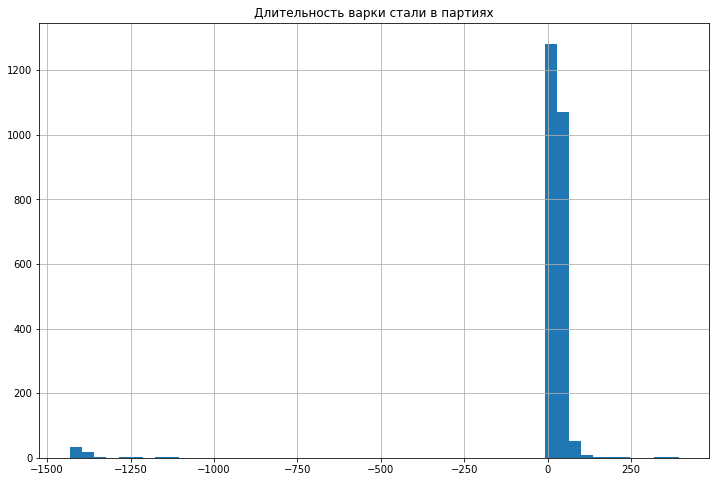

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
(temperature["measure_duration"] / pd.Timedelta(minutes=1)).hist(bins=50, ax=ax)
ax.set_title("Длительность варки стали в партиях");

Исправим это, прибавив к временным меткам, которые меньше предыдущих 24 часа, переведя их таким образом в следующие сутки. 

In [62]:
temperature.loc[
    temperature["measure_duration"] < timedelta(0), "measure_duration"
] += timedelta(hours=24)

Аналогичная ситуация возможна и в случае таблицы нагрева:

In [63]:
data_arc["heat_duration"] = data_arc["end_heat"] - data_arc["begin_heat"]

In [64]:
data_arc[data_arc["heat_duration"] < timedelta(0)]

,key,begin_heat,end_heat,active_power,reactive_power,heat_duration
580,126,1900-01-01 23:59:35,1900-01-01 00:01:55,0.53,0.41,-1 days +00:02:20
1170,257,1900-01-01 23:58:57,1900-01-01 00:00:07,0.27,0.18,-1 days +00:01:10
1280,280,1900-01-01 23:56:57,1900-01-01 00:01:43,1.20,0.73,-1 days +00:04:46
1953,421,1900-01-01 23:58:33,1900-01-01 00:01:57,0.77,0.58,-1 days +00:03:24
2952,642,1900-01-01 23:52:55,1900-01-01 00:03:13,2.42,1.95,-1 days +00:10:18
3438,745,1900-01-01 23:58:27,1900-01-01 00:00:14,0.40,0.28,-1 days +00:01:47
4250,913,1900-01-01 23:58:22,1900-01-01 00:01:34,0.79,0.54,-1 days +00:03:12
4752,1026,1900-01-01 23:59:04,1900-01-01 00:07:07,1.68,1.40,-1 days +00:08:03
5400,1175,1900-01-01 23:59:25,1900-01-01 00:05:07,1.33,0.89,-1 days +00:05:42
6456,1404,1900-01-01 23:56:33,1900-01-01 00:01:05,1.22,0.83,-1 days +00:04:32


In [65]:
data_arc.loc[data_arc["heat_duration"] < timedelta(0), "heat_duration"] += timedelta(
    hours=24
)

In [67]:
data_temp

,key,measure_time,temperature
0,1,1900-01-01 11:16:18,1571.0
1,1,1900-01-01 11:25:53,1604.0
2,1,1900-01-01 11:29:11,1618.0
3,1,1900-01-01 11:30:01,1601.0
4,1,1900-01-01 11:30:39,1613.0
...,...,...,...
12262,2498,1900-01-01 02:19:26,1593.0
12263,2498,1900-01-01 02:25:31,1594.0
12264,2499,1900-01-01 02:40:25,1569.0
12265,2499,1900-01-01 02:54:24,1604.0


In [68]:
pd.to_datetime(data_temp['measure_time'], format='%Y-%m-%d %H:%M:%S')

0       1900-01-01 11:16:18
1       1900-01-01 11:25:53
2       1900-01-01 11:29:11
3       1900-01-01 11:30:01
4       1900-01-01 11:30:39
                ...        
12262   1900-01-01 02:19:26
12263   1900-01-01 02:25:31
12264   1900-01-01 02:40:25
12265   1900-01-01 02:54:24
12266   1900-01-01 03:00:28
Name: measure_time, Length: 12265, dtype: datetime64[ns]

Ещё один момент, связанный со временем: часть этапов нагрева стали происходит до первого замера. Не станет ли это проблемой? По идее, эта работа электродов уже учтена в первом замере температуры. Тоже и с легирующими добавками: нужно ли их учитывать, если они применены до первого замера температуры? Пока не ясно.

### Вывод

Были проверены интервалы замеров температуры и нагревания. Внутрь некоторых из них попала полночь, так что значение времени в конце оказывалось меньше, чем в начале и длительность интервала - отрицательна. Исправлено 

## Изучение характеристик ключевых признаков процесса и построение дополнительных признаков 

Прежде чем переходить к созданию новых фичей, изучим поведение уже доступных ключевых признаков.

Следует изучить следующие показатели процесса варки стали:
1. Сколько времени прошло между первым и последним замером температуры.
1. Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродами.
1. Количество запусков нагрева электродами.
1. Среднее соотношение потребления активной и реактивной мощности.

По всем свойствам вычислим статистические показатели: средние, минимальные и квартили.

In [93]:
temperature.columns

Index(['measure_time_last', 'measure_time_first', 'temperature_last',
       'temperature_first', 'measure_duration'],
      dtype='object')

In [94]:
data_arc["full_power"] = np.sqrt(
    data_arc["active_power"] ** 2 + data_arc["reactive_power"] ** 2
)

In [95]:
data_arc["active_power_rate"] = data_arc["active_power"] / data_arc["full_power"]

In [96]:
features = temperature.join(
    data_arc.groupby("key").agg(
        heat_count=("heat_duration", "count"),
        active_power_rate=("active_power_rate", "mean"),
        full_power=("full_power", "sum"),
        heat_duration=("heat_duration", "sum"),
    )
)

In [97]:
features.head()

,measure_time_last,measure_time_first,temperature_last,temperature_first,measure_duration,heat_count,active_power_rate,full_power,heat_duration
key,,,,,,,,,
1,1900-01-01 11:30:39,1900-01-01 11:16:18,1613.0,1571.0,0 days 00:14:21,5,0.84,5.83,0 days 00:18:18
2,1900-01-01 11:59:12,1900-01-01 11:37:27,1602.0,1581.0,0 days 00:21:45,4,0.84,3.65,0 days 00:13:31
3,1900-01-01 12:34:57,1900-01-01 12:13:17,1599.0,1596.0,0 days 00:21:40,5,0.85,2.99,0 days 00:10:55
4,1900-01-01 12:59:25,1900-01-01 12:52:57,1625.0,1601.0,0 days 00:06:28,4,0.84,3.81,0 days 00:12:21
5,1900-01-01 13:36:01,1900-01-01 13:23:19,1602.0,1576.0,0 days 00:12:42,4,0.83,4.04,0 days 00:14:29


In [98]:
features[
    ["measure_duration", "heat_count", "active_power_rate", "heat_duration"]
].describe()

,measure_duration,heat_count,active_power_rate,heat_duration
count,2475,2475.00,2475.00,2475
mean,0 days 00:30:54.953939393,4.63,0.80,0 days 00:13:19.951919191
std,0 days 00:21:41.241763866,1.61,0.03,0 days 00:05:40.784276206
min,0 days 00:03:54,1.00,0.55,0 days 00:00:57
25%,0 days 00:19:42.500000,4.00,0.79,0 days 00:09:33
50%,0 days 00:26:33,4.00,0.81,0 days 00:12:52
75%,0 days 00:37:42.500000,6.00,0.82,0 days 00:16:26.500000
max,0 days 06:32:17,16.00,0.87,0 days 01:09:49


Время между первым и последним замерами температуры варируется в диапазоне от примерно 4 минут до 6,5 часов со средним 31 минут и медианой 26,5 минут.

Время прогрева стали в процессе выплавки меняется от минуты до примерно 1 часа 10 минут. Среднее 13,3 минуты, медиана чуть меньше 13 минут

Количество циклов прогрева составляет от 1 до 16 с медианой 4 и средним 4,6

Рассмотрим соотношение активной и реактивной мощности. В среднем активная мощность составляет 80% от полной, медиана - 81%, минимум - 42%, максимум - 87%.

Преобразуем временниые инервалы в минуты.

In [99]:
features["measure_duration"] = features["measure_duration"] / timedelta(minutes=1)
features["heat_duration"] = features["heat_duration"] / timedelta(minutes=1)

Попробуем представить полученные результаты более наглядно.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


ValueError: Could not interpret input 'measure_duration'

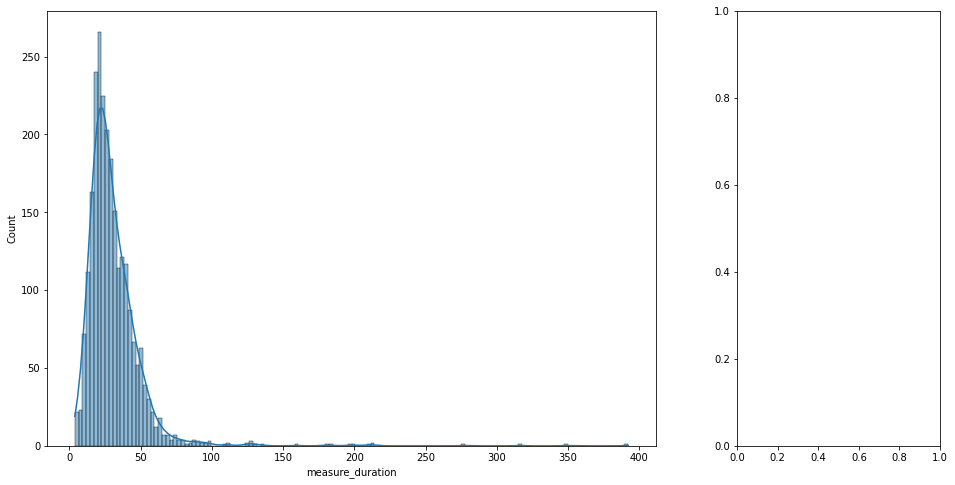

In [100]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 8), gridspec_kw={"width_ratios": [3, 1]}
)
sns.histplot(features, x="measure_duration", kde=True, ax=ax1)
sns.boxplot(features, y="measure_duration", ax=ax2)
fig.suptitle("Графики распределений периода изменений температуры")
ax1.set(
    xlabel="Время между первым и последним замерами температуры",
    ylabel="Количество партий стали",
)
ax2.set(ylabel="Время между первым и последним замерами температуры")

ax1.axvline(x=features["measure_duration"].mean(), color="red")
ax1.axvline(x=features["measure_duration"].median(), color="green")
l1 = mlines.Line2D([], [], color="red", label="mean")
l2 = mlines.Line2D([], [], color="green", label="median")
ax1.legend(handles=[l1, l2]);

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 8), gridspec_kw={"width_ratios": [3, 1]}
)
sns.histplot(features, x="heat_duration", kde=True, ax=ax1)
sns.boxplot(features, y="heat_duration", ax=ax2)
fig.suptitle("Графики распределений длительности нагрева")
ax1.set(xlabel="Суммарное время прогрева стали", ylabel="Количество партий стали")
ax2.set(ylabel="Суммарное время прогрева стали")

ax1.axvline(x=features["heat_duration"].mean(), color="red")
ax1.axvline(x=features["heat_duration"].median(), color="green")
l1 = mlines.Line2D([], [], color="red", label="mean")
l2 = mlines.Line2D([], [], color="green", label="median")
ax1.legend(handles=[l1, l2]);

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


ValueError: Could not interpret input 'heat_count'

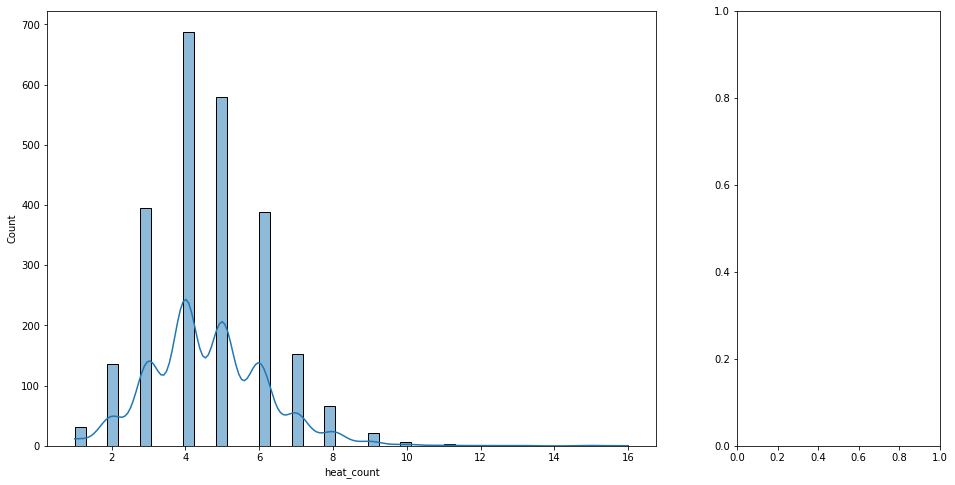

In [101]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 8), gridspec_kw={"width_ratios": [3, 1]}
)
sns.histplot(features, x="heat_count", kde=True, ax=ax1)
sns.boxplot(features, y="heat_count", ax=ax2)
fig.suptitle("Графики распределения циклов прогрева")
ax1.set(xlabel="Количество включений электродов", ylabel="Количество партий стали")
ax2.set(ylabel="Количество включений электродов")

ax1.axvline(x=features["heat_count"].mean(), color="red")
ax1.axvline(x=features["heat_count"].median(), color="green")
l1 = mlines.Line2D([], [], color="red", label="mean")
l2 = mlines.Line2D([], [], color="green", label="median")
ax1.legend(handles=[l1, l2]);

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


ValueError: Could not interpret input 'active_power_rate'

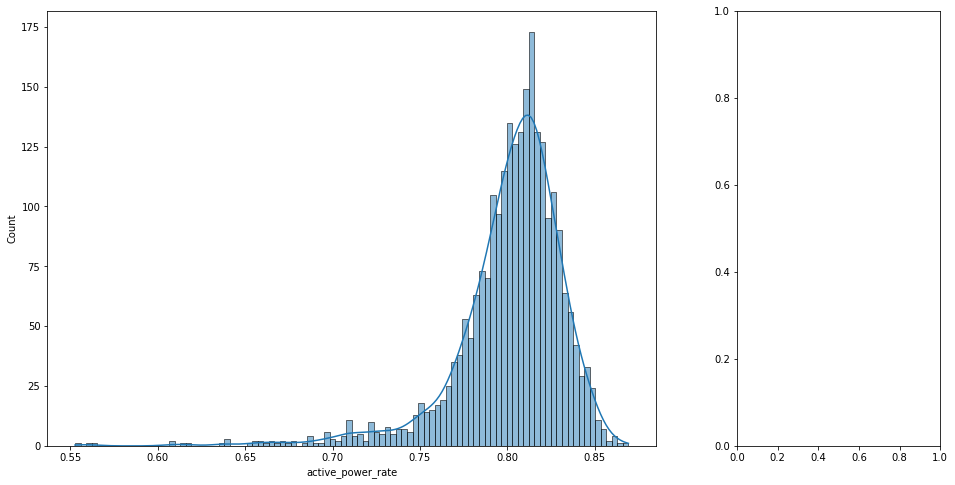

In [102]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 8), gridspec_kw={"width_ratios": [3, 1]}
)
sns.histplot(features, x="active_power_rate", kde=True, bins=100, ax=ax1)
sns.boxplot(features, y="active_power_rate", ax=ax2)
fig.suptitle("Графики распределения доли активной можности от полной")
ax1.set(xlabel="Доля активной мощности", ylabel="Количество партий стали")
ax2.set(ylabel="Доля активной мощности")

ax1.axvline(x=features["active_power_rate"].mean(), color="red")
ax1.axvline(x=features["active_power_rate"].median(), color="green")
l1 = mlines.Line2D([], [], color="red", label="mean")
l2 = mlines.Line2D([], [], color="green", label="median")
ax1.legend(handles=[l1, l2]);

Мы уже построили некоторое количество дополнительных признаков, теперь добавим в таблицу признаков информацию о легирующих добавках.

In [103]:
features = (
    features.join(data_bulk.set_index("key"), how="inner")
    .join(data_wire.set_index("key"), how="inner")
    .join(data_gas.set_index("key"), how="inner")
)

In [104]:
features.isna().sum()

measure_time_last        0
measure_time_first       0
temperature_last         0
temperature_first        0
measure_duration         0
heat_count               0
active_power_rate        0
full_power               0
heat_duration            0
bulk_1                2130
bulk_3                1369
bulk_4                1517
bulk_6                1891
bulk_10               2186
bulk_11               2199
bulk_12                517
bulk_14                261
bulk_15                630
wire_1                  23
wire_2                1518
gas                      0
dtype: int64

Пропусков в данных по температуре, нагреву и газу нет, но по присадкам есть и их нужно заполнить.

In [105]:
features = features.fillna(0)

Проверим, нет ли партий стали, в которых совсем нет легирующих добавок: 

In [106]:
features[
    (features["bulk_1"] == 0)
    & (features["bulk_3"] == 0)
    & (features["bulk_4"] == 0)
    & (features["bulk_6"] == 0)
    & (features["bulk_10"] == 0)
    & (features["bulk_11"] == 0)
    & (features["bulk_12"] == 0)
    & (features["bulk_14"] == 0)
    & (features["bulk_15"] == 0)
    & (features["wire_1"] == 0)
    & (features["wire_2"] == 0)
]

,measure_time_last,measure_time_first,temperature_last,temperature_first,measure_duration,heat_count,active_power_rate,full_power,heat_duration,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas
key,,,,,,,,,,,,,,,,,,,,,
114,1900-01-01 10:38:12,1900-01-01 09:49:47,1600.0,1631.0,48.42,3,0.79,2.75,8.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.68


Одна партия нашлась. Поскольку по техпроцессу легирование должно быть всегда, значит здесь ошибка, удалим эту запись. 

In [107]:
features = features.drop(
    index=features[
        (features["bulk_1"] == 0)
        & (features["bulk_3"] == 0)
        & (features["bulk_4"] == 0)
        & (features["bulk_6"] == 0)
        & (features["bulk_10"] == 0)
        & (features["bulk_11"] == 0)
        & (features["bulk_12"] == 0)
        & (features["bulk_14"] == 0)
        & (features["bulk_15"] == 0)
        & (features["wire_1"] == 0)
        & (features["wire_2"] == 0)
    ].index
)

In [108]:
features.head()

,measure_time_last,measure_time_first,temperature_last,temperature_first,measure_duration,heat_count,active_power_rate,full_power,heat_duration,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas
key,,,,,,,,,,,,,,,,,,,,,
1,1900-01-01 11:30:39,1900-01-01 11:16:18,1613.0,1571.0,14.35,5,0.84,5.83,18.30,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.06,0.00,29.75
2,1900-01-01 11:59:12,1900-01-01 11:37:27,1602.0,1581.0,21.75,4,0.84,3.65,13.52,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.05,0.00,12.56
3,1900-01-01 12:34:57,1900-01-01 12:13:17,1599.0,1596.0,21.67,5,0.85,2.99,10.92,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.16,0.00,28.55
4,1900-01-01 12:59:25,1900-01-01 12:52:57,1625.0,1601.0,6.47,4,0.84,3.81,12.35,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.06,0.00,18.84
5,1900-01-01 13:36:01,1900-01-01 13:23:19,1602.0,1576.0,12.70,4,0.83,4.04,14.48,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.24,9.11,5.41


In [109]:
features

,measure_time_last,measure_time_first,temperature_last,temperature_first,measure_duration,heat_count,active_power_rate,full_power,heat_duration,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas
key,,,,,,,,,,,,,,,,,,,,,
1,1900-01-01 11:30:39,1900-01-01 11:16:18,1613.0,1571.0,14.35,5,0.84,5.83,18.30,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.06,0.00,29.75
2,1900-01-01 11:59:12,1900-01-01 11:37:27,1602.0,1581.0,21.75,4,0.84,3.65,13.52,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.05,0.00,12.56
3,1900-01-01 12:34:57,1900-01-01 12:13:17,1599.0,1596.0,21.67,5,0.85,2.99,10.92,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.16,0.00,28.55
4,1900-01-01 12:59:25,1900-01-01 12:52:57,1625.0,1601.0,6.47,4,0.84,3.81,12.35,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.06,0.00,18.84
5,1900-01-01 13:36:01,1900-01-01 13:23:19,1602.0,1576.0,12.70,4,0.83,4.04,14.48,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.24,9.11,5.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1900-01-01 00:54:42,1900-01-01 00:35:45,1591.0,1570.0,18.95,4,0.81,3.99,12.05,0.0,21.0,0.0,0.0,90.0,0.0,256.0,129.0,223.0,89.15,0.00,7.13
2496,1900-01-01 01:29:52,1900-01-01 01:02:54,1591.0,1554.0,26.97,6,0.83,5.06,15.67,0.0,0.0,63.0,0.0,122.0,0.0,256.0,129.0,226.0,114.18,0.00,9.41
2497,1900-01-01 01:53:50,1900-01-01 01:41:53,1589.0,1571.0,11.95,3,0.77,2.89,9.48,0.0,0.0,85.0,0.0,0.0,0.0,230.0,124.0,226.0,94.09,9.05,6.27


Посмотрим парные корреляции между признаками. Выше мы видели, что распределение показателей не соответствует нормальному, поэтому используем корреляцию Спирмана

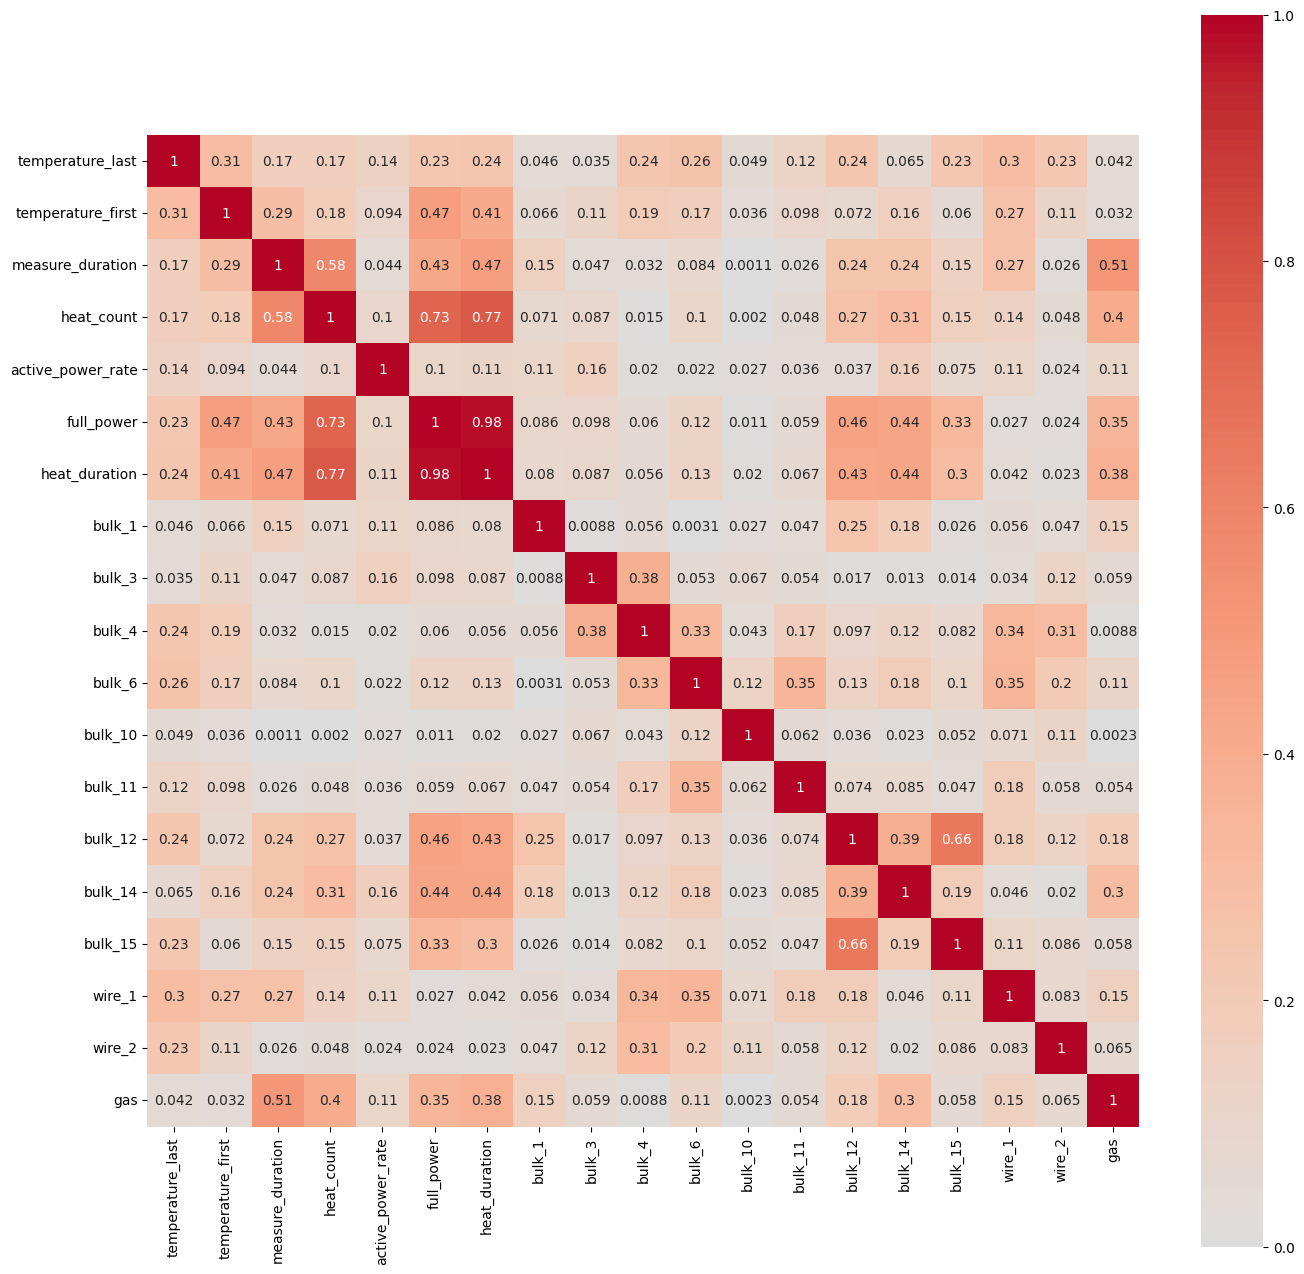

In [135]:
corr = abs(features.corr(method="spearman"))

fig, ax = plt.subplots(figsize=(16, 16))

font = {"size": 10}
plt.rc("font", **font)


ax = sns.heatmap(
    corr,
    cmap=sns.color_palette("coolwarm", as_cmap=True),
    annot=True,
    vmax=1,
    vmin=0,
    center=0,
    square=True,
    linewidths=0,
    xticklabels=True,
    yticklabels=True,
)

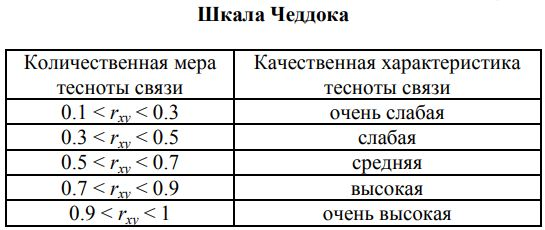

Нас интересуют корреляции выше 0,9. Видно, что такие сильные связи имеются между full_power и heat_duration (0,98). Избавимся от full_power.

In [110]:
features = features.drop(columns=["full_power"])

In [111]:
X = features.drop(
    ["temperature_last", "measure_time_last", "measure_time_first"], axis=1
)
y = features["temperature_last"]

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [113]:
scaler = StandardScaler()
scaler.fit(X_train)

cols = X_train.columns
X_train[cols] = scaler.transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

In [114]:
X_train.head()

,temperature_first,measure_duration,heat_count,active_power_rate,heat_duration,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas
key,,,,,,,,,,,,,,,,,
249,1.72,-0.07,-1.66,0.55,-1.52,-0.26,-0.63,0.44,-0.41,-0.24,-0.19,-1.33,-1.89,-1.44,2.92e-02,-0.52,-0.21
1151,-0.32,-0.61,-1.04,-0.58,0.48,1.94,-0.63,1.26,-0.41,-0.24,-0.19,1.30,0.73,1.00,7.29e-01,-0.52,0.25
906,-0.66,-0.42,0.18,-0.11,0.37,-0.26,0.96,-0.63,-0.41,-0.24,-0.19,0.30,-0.63,-0.21,-1.06e+00,-0.52,-0.57
2270,-0.42,-0.69,-0.43,0.38,-0.41,-0.26,-0.63,-0.63,-0.41,3.60,-0.19,-0.02,-0.42,-0.20,-4.88e-01,0.12,0.11
24,-0.28,1.06,0.79,1.28,1.08,-0.26,0.53,-0.63,1.51,-0.24,-0.19,1.31,0.62,0.97,8.24e-03,0.97,0.03


### Вывод

1. Изучили распределение ключевых признаков процесса варки стали. 
1. Построили дополнительные признаки.
1. Избавились от линейносвязанных признаков.
1. Отнормировали данные.
1. Подготовили тренировочную и валидационную выборки.

## Обучение моделей

Обучим на наших данных несколько моделей и посмотрим, каких значений MAE удастся добиться. Наша цель - значение метрики менее 6.3.

### Линейная регрессия

In [115]:
%%time

lr = LinearRegression()
cv_MAE_LR = (
    cross_val_score(
        lr, X_train, y_train, cv=5, scoring="neg_mean_absolute_error"
    ).mean()
    * -1
)
print(f"Mean MAE on CV of LinearRegression = {cv_MAE_LR}")

Mean MAE on CV of LinearRegression = 6.420285355960749
CPU times: user 90.7 ms, sys: 149 ms, total: 240 ms
Wall time: 159 ms


Ошибка не существенно, но больше нашего целевого уровня, так что проверять на валидационной выборке даже нет смысла.

### Случайный лес

In [142]:
%%time

rf = RandomForestRegressor(random_state=42, criterion="absolute_error")
params = [
    {
        "max_depth": [x for x in range(5, 50 + 1, 5)],
        "n_estimators": [x for x in range(100, 1500 + 1, 100)],
    }
]

rf_gs = GridSearchCV(rf, params, scoring="neg_mean_absolute_error", cv=3, n_jobs=-1)

rf_gs.fit(X_train, y_train)
print(f"Best parameters set found on development set: {rf_gs.best_params_}")
print("Grid scores on development set:")
means = rf_gs.cv_results_["mean_test_score"]
stds = rf_gs.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, rf_gs.cv_results_["params"]):
    print("%0.6f for %r" % ((mean * -1), params))
print()
print(f"Mean MAE on CV of Random Forest = {max(means) * -1}")

In [143]:
rf_gs.best_estimator_

На модели случайного леса удалось достич на валидационной выборке желаемой метрики.

### Бустинг

В качестве модели бустинга будем использовать LGBMBoost: в рамках курса она показала хорошие точность и скорость.

In [144]:
%%time

lgbm = LGBMRegressor(random_state=42)
params = [
    {
        "num_leaves": [x for x in range(10, 31)],
        "learning_rate": [x / 100 for x in range(1, 11)],
    }
]


lgbm_gs = GridSearchCV(lgbm, params, scoring="neg_mean_absolute_error", cv=3)
lgbm_gs.fit(X_train, y_train)
print(f"Best parameters set found on development set: {lgbm_gs.best_params_}")
print()
print("Grid scores on development set:")
means = lgbm_gs.cv_results_["mean_test_score"]
stds = lgbm_gs.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, lgbm_gs.cv_results_["params"]):
    print("%0.6f for %r" % ((mean * -1), params))
print()
print(f"Mean MAE on CV of LGBM = {max(means) * -1}")

Как и ожидалось, LGBM отработала существенно быстрее случайного леса с 1000+ деревьями и пооказала лучшую абсолютную ошибку.

### Неросеть

Наконец, обучим и оптимизируем нейнонную сеть. В качестве основы используем нейросет на полносвязных слоях. Используем 2 скрытых слоя. В качестве регуляризирующего слоя будем использовать BatchNormalization после каждого скрытого слоя

Прежде всего зафиксируем внутренний генератор ПСЧ tensorflow 

In [145]:
random.seed(42)
np.random.seed(42)
set_random_seed(42)

In [146]:
y_train.describe()

Целевые признаки (температуры в конце выплавки) колеблются в относительно узком диапазоне возле достаточно высокго среднего значения. Это создаёт некоторые сложности в обучении нейросети. Поможем ей вычтя из целевого признака среднее. В дальнейшем, это значение нужно будет прибавлять к прогнозу модели для получения предсказанных значений температур 

In [160]:
y_mean = y_train.mean().item()

In [161]:
y_train = y_train - y_mean
y_test = y_test - y_mean

In [162]:
f_num = X.shape[1]

In [184]:
input_shape = (f_num,)


def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    for i in range(hp.Int("num_layers", 2, 3)):
        model.add(
            Dense(
                units=hp.Int(f"units_{i}", min_value=60, max_value=70 + 1, step=1),
                activation=hp.Choice("activation", ["relu", "elu"]),
            )
        )
        # if hp.Boolean(f"dropout_{i}"):
        #     model.add(Dropout(rate=0.25))
    model.add(Dense(1, activation="relu"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mae"],
    )
    return model

In [187]:
stop_early = EarlyStopping(monitor="val_mae", patience=5)

In [188]:
hb_tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_mae",
    max_epochs=1000,
    factor=3,
    directory="my_dir",
    project_name="steel_hb_1",
)
hb_tuner.search_space_summary()

In [189]:
%%time

hb_tuner.search(
    X_train,
    y_train,
    epochs=200,
    validation_split=0.2,
    callbacks=[stop_early],
)

Выложил архив с данными, сохранёнными тюнером на Яндекс.диск: https://disk.yandex.ru/d/cba8EkR2cYWfzQ

In [197]:
best_hps = hb_tuner.get_best_hyperparameters(num_trials=1)[0]
net = hb_tuner.hypermodel.build(best_hps)

In [198]:
net.summary()

Дообучим нашу лучшую модель на большем количестве эпох

In [200]:
history = net.fit(X_train, y_train, epochs=500, validation_split=0.2)

val_mae_per_epoch = history.history["val_mae"]
best_epoch = val_mae_per_epoch.index(max(val_mae_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

Увы, не смотря на оптимизации, достичь желаемого значения MAE<6.3 так и не удалось

## Выбор победителя и тестирование лучшей модели

По итогам подбора гиперпараметров и обучения моделей, мы получили следующие результаты для разных моделей:

In [203]:
pd.DataFrame(
    {
        "model": ["Линейная регрессия", "Случайный лес", "LGBM", "Нейронная сеть"],
        "MAE": [6.42, 6.25, 5.97, 6.85],
    }
)

Как видно, наилучший результат демонстрирует модель LGBM. Посмотрим, какой результат она покажет на тестовой выборке

In [202]:
lgbm = lgbm_gs.best_estimator_
# мы обучали модель бустинга на выборке с ненулевым средним, так что добавим среднее обратно
mean_absolute_error(y_test + y_mean, lgbm.predict(X_test))

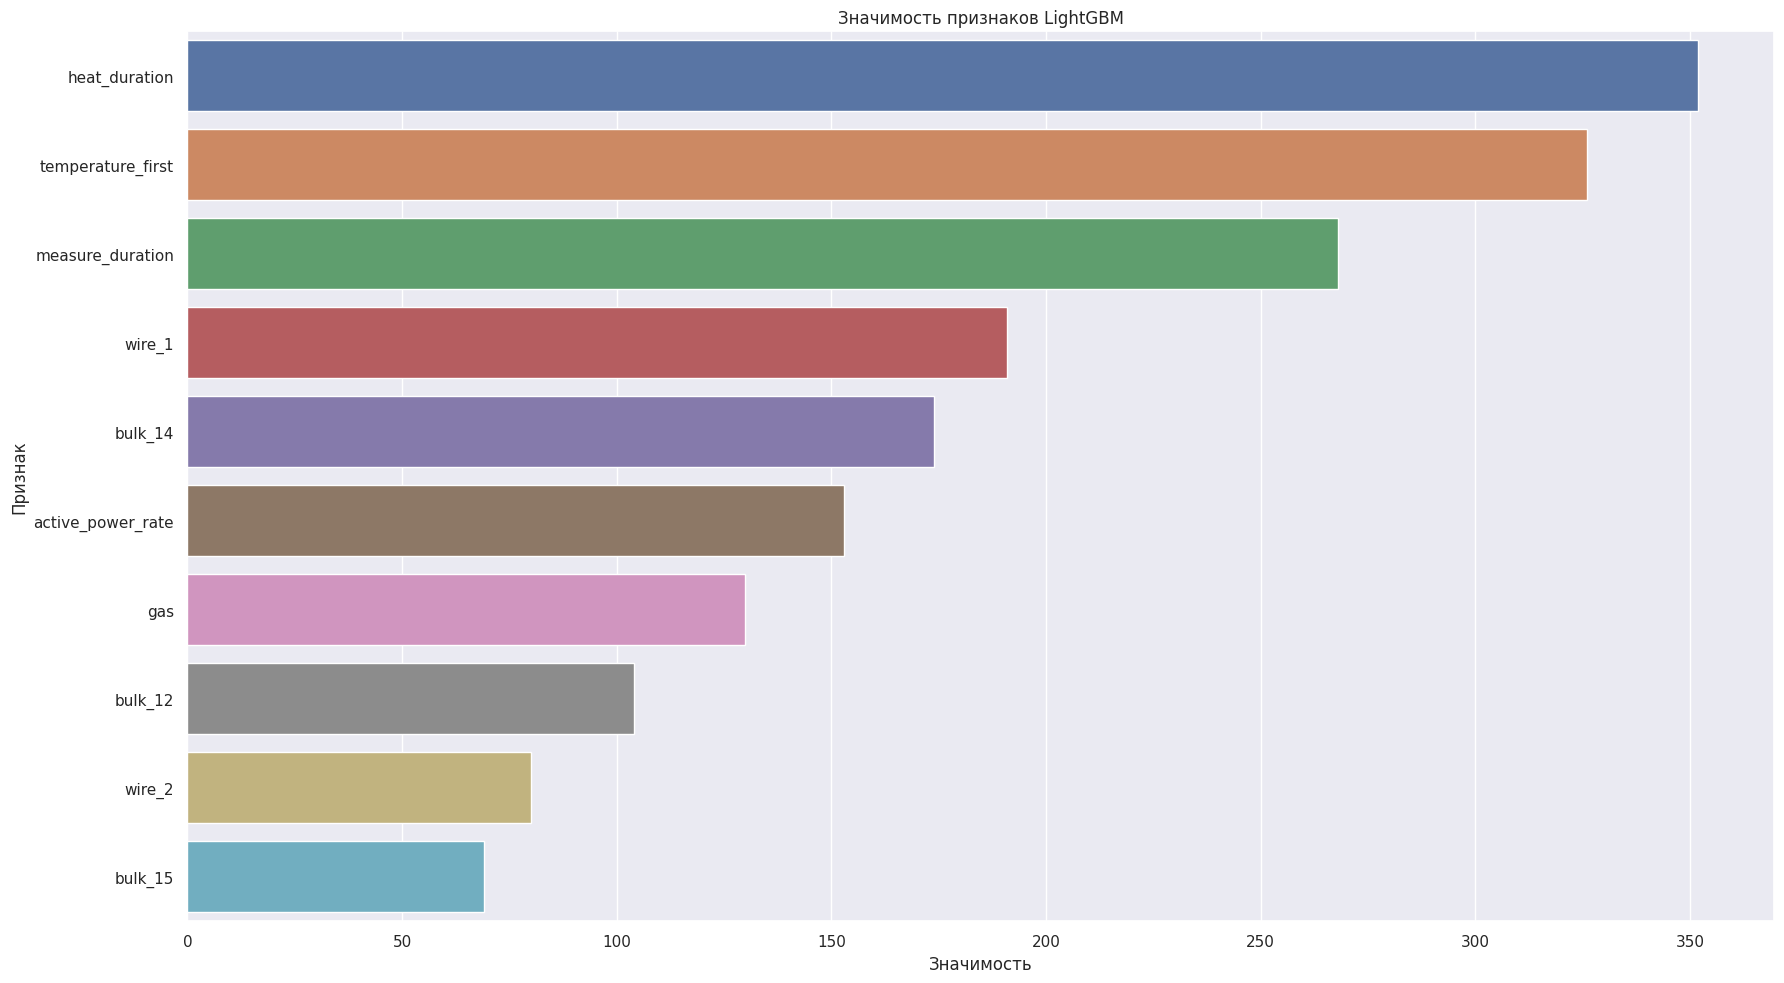

In [216]:
feature_imp = pd.DataFrame({"Value": lgbm.feature_importances_, "Feature": X.columns})
plt.figure(figsize=(18, 10))
sns.set(font_scale=1)
g = sns.barplot(
    x="Value",
    y="Feature",
    data=feature_imp.sort_values(by="Value", ascending=False)[0:10],
)
g.set(xlabel="Значимость", ylabel="Признак")
plt.title("Значимость признаков LightGBM")
plt.tight_layout()

В целом не удивительно, что наиболее значимымми признаками в предсказании оказались время нагрева, напрямую влияющее на количество тепла, передаваемого стали, а также начальная температупа стали. Далее по значимости идут менее очевидные длительность периода замера температуры (т.е. длительность варки стали) и использование двух легирующих добавок. Но их влияние примерно вдвое меньше, чем первых двух. 

In [125]:
X = features.drop(
    ["temperature_last", "measure_time_last", "measure_time_first", 'measure_duration', 'heat_duration'], axis=1
)
y = features["temperature_last"]

In [126]:
X

,temperature_first,heat_count,active_power_rate,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas
key,,,,,,,,,,,,,,,
1,1571.0,5,0.84,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.06,0.00,29.75
2,1581.0,4,0.84,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.05,0.00,12.56
3,1596.0,5,0.85,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.16,0.00,28.55
4,1601.0,4,0.84,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.06,0.00,18.84
5,1576.0,4,0.83,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.24,9.11,5.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,4,0.81,0.0,21.0,0.0,0.0,90.0,0.0,256.0,129.0,223.0,89.15,0.00,7.13
2496,1554.0,6,0.83,0.0,0.0,63.0,0.0,122.0,0.0,256.0,129.0,226.0,114.18,0.00,9.41
2497,1571.0,3,0.77,0.0,0.0,85.0,0.0,0.0,0.0,230.0,124.0,226.0,94.09,9.05,6.27


In [127]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [136]:
optimizer = Adam(lr=0.001)

features_train, features_test, target_train, target_test = train_test_split(
    X, y, test_size=0.2, random_state=12345
)

scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

# target_train = data_train["Temperature_y"]
# features_train = data_train.drop(["Temperature_y"], axis=1)

# target_test = data_test["Temperature_y"]
# features_test = data_test.drop(["Temperature_y"], axis=1)

#normalizer = keras.layers.Normalization(axis=-1)
#normalizer.adapt(np.array(features_train))

model_keras = keras.models.Sequential()
#model_keras.add(normalizer)
model_keras.add(keras.layers.Dense(units=64, activation="relu"))
model_keras.add(keras.layers.Dense(units=64, activation="relu"))
#
model_keras.add(keras.layers.Dense(units=1))
model_keras.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mae"])

#model_keras.summary()

model_keras.fit(
    features_train,
    target_train,
    validation_data=(features_test, target_test),
    verbose=2,
    epochs=700,
)

Epoch 1/700
59/59 - 1s - loss: 2527716.7500 - mae: 1589.8375 - val_loss: 2508417.7500 - val_mae: 1583.7565 - 940ms/epoch - 16ms/step
Epoch 2/700
59/59 - 0s - loss: 2464092.0000 - mae: 1569.6483 - val_loss: 2394304.5000 - val_mae: 1547.2535 - 204ms/epoch - 3ms/step
Epoch 3/700
59/59 - 0s - loss: 2269026.0000 - mae: 1505.7684 - val_loss: 2098697.0000 - val_mae: 1447.9860 - 196ms/epoch - 3ms/step
Epoch 4/700
59/59 - 0s - loss: 1860832.2500 - mae: 1360.9641 - val_loss: 1576930.6250 - val_mae: 1251.4266 - 204ms/epoch - 3ms/step
Epoch 5/700
59/59 - 0s - loss: 1268013.1250 - mae: 1114.0891 - val_loss: 942654.8750 - val_mae: 952.8458 - 192ms/epoch - 3ms/step
Epoch 6/700
59/59 - 0s - loss: 677293.0000 - mae: 787.6749 - val_loss: 437843.1250 - val_mae: 615.8972 - 254ms/epoch - 4ms/step
Epoch 7/700
59/59 - 0s - loss: 303156.0625 - mae: 487.9982 - val_loss: 196680.3750 - val_mae: 382.7122 - 207ms/epoch - 4ms/step
Epoch 8/700
59/59 - 0s - loss: 156662.3594 - mae: 326.6090 - val_loss: 124583.0547 - 

### Вывод

Были построены и обучены различные модели. Для всех, кроме линейной регрессии удалось достичь целевой метрики $MAE < 6.3$

1. Случайный лес после долгого обучения показал на кросскалидации MAE=6.25
1. Модель LGBM обучилась почти в 40 раз быстрее и показала MAE=5.97
1. Нейросеть на Keras - 6.8

Как итог, в нынешнем виде из всех моделей наиболее перспективной представляется бустинг: модель обучается быстро, даёт устойчивые результаты. Тогда как изученная неросеть даёт очень разные точности прогноза с небольшим изенением гиперпараметров, что сильно затрутняет обучение и делает результат трудно предсказуемым.  

In [15]:
pd.read_sql_query(
    "select * from steel.data_arc",
    con=engine,
).head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.98,0.69
1,1,11:07:28,11:10:33,0.81,0.52
2,1,11:11:44,11:14:36,0.74,0.50
3,1,11:18:14,11:24:19,1.66,1.06
4,1,11:26:09,11:28:37,0.69,0.41


data_temp['time_measure'] = pd.to_datetime('11:02:14', format='%Y-%m-%d %H:%M:%S')